In [75]:
# 53:05

In [ ]:
!pip3 install matplotlib
!pip3 install graphviz

In [77]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
def f(x):
    return 3*x**2 - 4*x + 5

In [79]:
f(3.0)

20.0

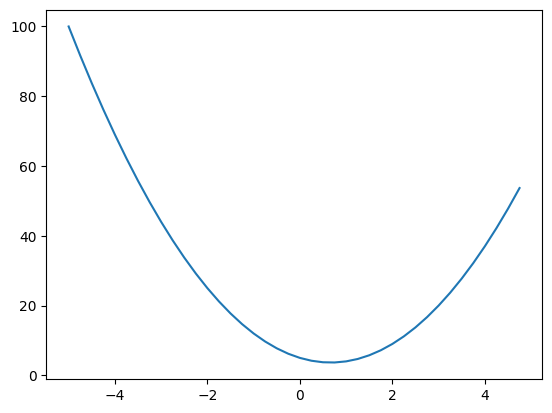

In [80]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

# What is a derivative
If you look at the formula
L = lim (h -> 0) (f(x + h) - f(x)) / h

This states that if you slightly bump up x by a small amount, with what sensitivity does it respond. That is, what is its slope. Does it go up or down and by how much?

In [81]:
# Derivate of a simple function with one input 
h = 0.000001
x = 3
(f(x + h) - f(x)) / h

14.000003002223593

In [82]:
# Let's get a bit complex
# Derivative of a function with multiple inputs
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0


d1 = a*b + c
d2 = (a + h)*b + c 
print(d1, d2)
print((d2 - d1) / h) # derivate of d wrt a ==> b

d3 = a*(b + h) + c
print((d3 - d1) / h) # derivate of d wrt b ==> a

d4 = a*b + c + h
print((d4 - d1) / h) # derivate of d wrt c ==> 1

4.0 3.999699999999999
-3.000000000010772
2.0000000000042206
0.9999999999976694


# Neural networks
They will be pretty massive mathematical expressions (just a class of mathematical expressions). We will need some data structures that will help maintain these expressions. This is the where the below class Value will help.

In [153]:
class Value:

    def __init__(self, data, _children=(), _op = '', label = '', grad = 0.0):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = grad
        # applicable for leaf node
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        self.grad = 1
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2, label='f')
L = d * f; L.label = 'L'
L
# (a.__mul__(b)).__add__(c)

Value(data=-8.0, label=L)

In [91]:
d._prev

{Value(data=-6.0, label=e), Value(data=10.0, label=c)}

In [102]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this op node to the result node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

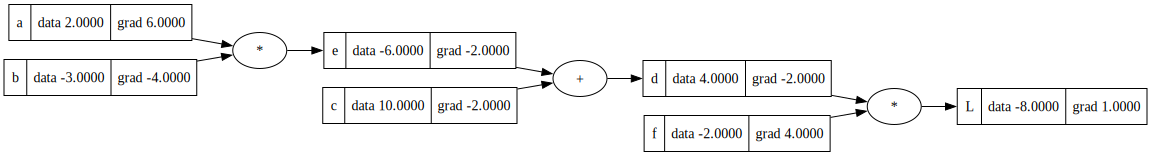

In [104]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0
c.grad = -2.0
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

# Back propagation
* What we did above was forward pass.
* In back propagation, we are going to go reverse and calculate the gradient along all the intermediate values.
* We will calculate the derivate of L (loss function) wrt every node (weights). This is what is required in a neural network.
* In one example, we will do back propagation manually.
* We calculated dL/dd = f and dL/df = d
* For calculating de/dc, we applied chain rule in calculus. dL/dc = dL/dd.dd/dc.
    * If car is 4x the speed of cycle and cycle is 4x the speed of man, car is 8x the speed of man.
* Whenever we have a plus sign, in back propagation, the derivative would be just passed on, this is because the derivative will always be constant and after chain rule, it would just multiply by 1.
* Similarly, when we have a multiply sign, just by multiply the derivate of parent, with the opposite multiply node.

# Manual Back Propagation Optimization Example
* All of the nodes which are not dependent on any other nodes are leaf nodes or input nodes.
* In this case, a, b, c and f are leaf nodes.
* We want to increase the value of the loss function, which we will do by nudging these leaf nodes in the direction of the gradient and re-run the forward pass. 

In [105]:
# nudge in the direction of the gradient
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# re-run the forward pass
e = a*b
d = e + c
L = d*f
L # this increased value of L and made it slightly less negative.

Value(data=-7.286496, label=)

We will now take a slightly complex example for manual backpropagation with a neuron (a multi-layer perceptron).

x: inputs, w: weights of the inputs, b: can influence the output regardless of the input
sigma(wi xi) + b

* After that, we take it through some activation function. This activation function is usually some squashing function. eg: sigmoid or tanh.
* Eg: tanh: it will cap the output smoothly at 1 for positive values and will cap the output smoothly at -1 for negative values.

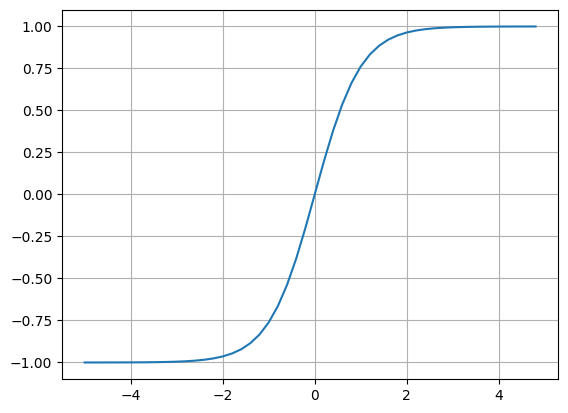

In [106]:
step_graph = np.arange(-5, 5, 0.2)
plt.plot(step_graph, np.tanh(step_graph))
plt.grid()

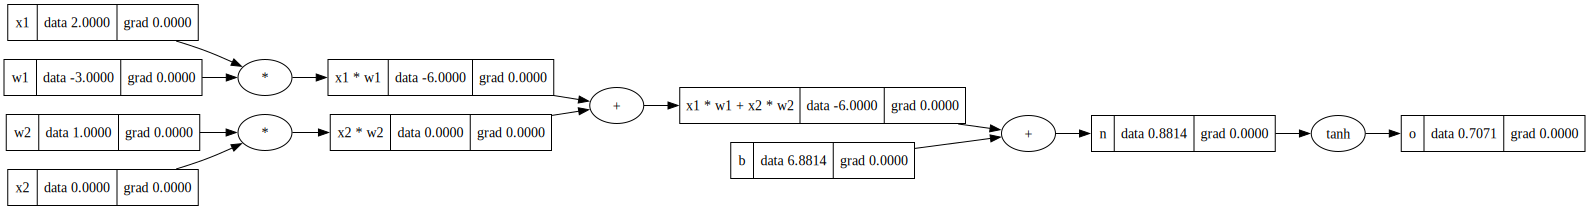

In [149]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights (synaptic strength of each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

# Manual Backpropagation of the Neuron
* do/do = 1
* o = tanh(n)
* do/dn = 1 - (tanh(n)**2) [this formula we can find online]
* do/dn = 1 - (o**2)
* If we see the below diagram, w2.grad = 0.0 as x2.data = 0. This makes sense because derivate always tells us the influence of the weight on the final output. If we change, w2 how is the output changing? It's not changing as the grad = 0.
* We can also see that w1.grad = 1, which tells us that if we want to change the output, increase w1 will linearly increase the output.

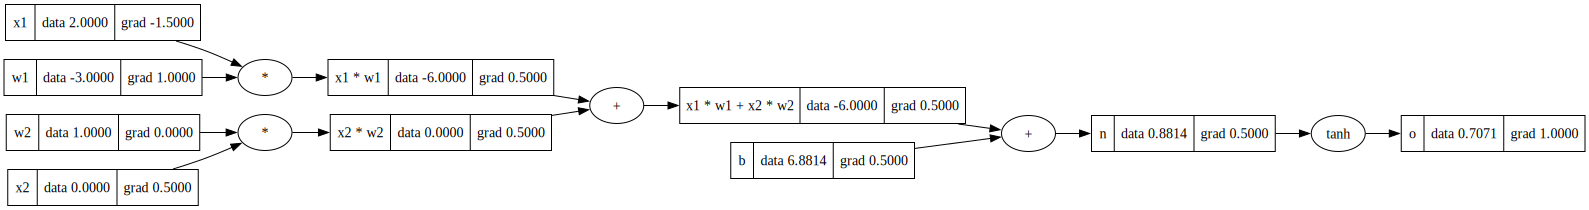

In [117]:
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = -1.5
w1.grad = 1.0
x2.grad = 0.5
w2.grad = 0.0
draw_dot(o)

In [145]:
def reset_grad():
    o.grad = 0.0
    n.grad = 0.0
    x1w1x2w2.grad = 0.0
    b.grad = 0.0
    x1w1.grad = 0.0
    x2w2.grad = 0.0
    x1.grad = 0.0
    w1.grad = 0.0
    x2.grad = 0.0
    w2.grad = 0.0
reset_grad()

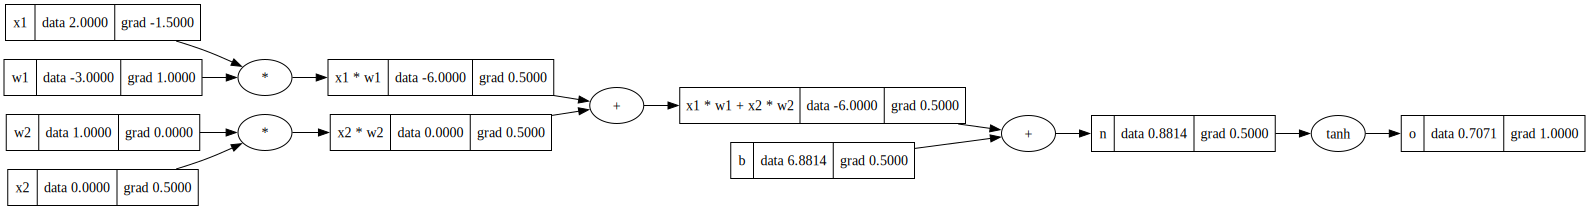

In [151]:
draw_dot(o)

In [136]:
# Implementing the backward function for each operation and calling them
o.grad = 1.0
o._backward()

n._backward()

b._backward()
x1w1x2w2._backward()

x1w1._backward()
x2w2._backward()

# Backward propagation for the whole expression graph
* The backward propagation works in such a way that in order for us to evaluate a node, all of its dependencies need to be evaluated first.
* This is what we do in topological sort. 

In [150]:
o.backward()

# Fixing a backprop bug when a node is used multiple times
* When a node is being used multiple times, its value will be overriden by the last value, rather than probably being the sum of the values. Example shared below:

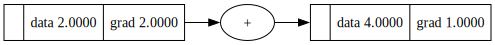

In [154]:
a = Value(2)
b = a + a
b.backward()
draw_dot(b) # a = 2 * b ==> db/da = 2 but this gave the ans as 1
# instead of self.grad = 1.0 * out.grad, we change it to self.grad += 1.0 * out.grad